In [11]:
import os
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

def read_nc_files_and_fill_missing(base_path, year_month):
    """
    从指定路径读取 .nc 文件，提取所需特征，并根据指定年月对缺失时间点填充 NaN，确保时间序列满足 10 分钟采样。

    参数：
    - base_path: str, 存放 .nc 文件的目录路径
    - year_month: str, 需要读取的年月标识（如 '201701'）

    返回：
    - data_array: np.ndarray，形状为 (5, expected_timesteps, 4)，浮标数、时间步、特征数
    """
    buoy_count = 5  # 固定浮标数量
    features = ['Hm0', 'tm02', 'mdir']  # 所需提取的特征
    all_data = []

    # 获取指定年月的起止时间
    year = int(year_month[:4])
    month = int(year_month[4:])
    start_date = datetime(year, month, 1, 0, 0)
    if month == 12:
        end_date = datetime(year + 1, 1, 1, 0, 0)
    else:
        end_date = datetime(year, month + 1, 1, 0, 0)

    # 计算期望时间步数，每 10 分钟一个时间点
    expected_timestamps = int((end_date - start_date).total_seconds() // 600)
    time_index = [start_date + timedelta(minutes=10 * i) for i in range(expected_timestamps)]

    # 找到指定年月的 5 个文件
    files = [f for f in os.listdir(base_path) if f.startswith(year_month) and f.endswith('.nc')]
    files = sorted(files)[:buoy_count]  # 按字母排序并选取前 5 个文件

    if len(files) != buoy_count:
        raise ValueError(f"文件数量不足！需要 5 个文件，但仅找到 {len(files)} 个。")

    # 读取每个文件的数据，并补齐时间步
    for file in files:
        file_path = os.path.join(base_path, file)

        with xr.open_dataset(file_path) as ds:
            # 提取时间变量
            time_var = ds['time'].values
            timestamps = [np.datetime64(t).astype(datetime) for t in time_var]
            
            # 调试：打印时间变量
            print(f"文件时间变量: {timestamps[:5]}")  # 打印前 5 个时间戳

            # 构建时间到索引的映射
            time_to_idx = {t: i for i, t in enumerate(timestamps)}

            # 调试：打印时间到索引的映射
            print(f"时间到索引映射: {list(time_to_idx.items())[:5]}")  # 打印前 5 个映射

            # 初始化完整时间轴数据为 NaN
            data = np.full((expected_timestamps, len(features) + 2), np.nan)

            for feature_idx, feature in enumerate(features):
                # 提取当前特征值
                values = ds[feature].values
                print(f"特征 {feature} 的前 5 个值: {values[:5]}")  # 调试：打印前 5 个特征值

                # 将特征值插入完整时间轴
                for i, t in enumerate(time_index):
                    if t in time_to_idx:
                        data[i, feature_idx] = values[time_to_idx[t]]
                    else:
                        # print(f"未匹配的时间步: {t}")  # 调试：记录未匹配时间步

            # 计算并填充 (cos(dirm), sin(dirm))
            dirm = data[:, 2]  # 平均波方向
            if not np.isnan(dirm).all():
                cos_dirm = np.cos(np.deg2rad(dirm))
                sin_dirm = np.sin(np.deg2rad(dirm))
                data[:, 3] = cos_dirm
                data[:, 4] = sin_dirm

            all_data.append(data)
            print(f"文件 {file} 处理完成，形状: {data.shape}")

    # 拼接为 (5, expected_timestamps, 5)
    data_array = np.stack(all_data, axis=0)
    return data_array


In [12]:
base_path = r"E:\Dataset\met_waves\buoy"
year_month = "201803"
data=read_nc_files_and_fill_missing(base_path, year_month)
data[0,0:10,:]


文件时间变量: [1519862400000000000, 1519863000000000000, 1519863600000000000, 1519864200000000000, 1519864800000000000]
时间到索引映射: [(1519862400000000000, 0), (1519863000000000000, 1), (1519863600000000000, 2), (1519864200000000000, 3), (1519864800000000000, 4)]
特征 Hm0 的前 5 个值: [0.32227 0.35156 0.35156 0.33691 0.33691]
未匹配的时间步: 2018-03-01 00:00:00
未匹配的时间步: 2018-03-01 00:10:00
未匹配的时间步: 2018-03-01 00:20:00
未匹配的时间步: 2018-03-01 00:30:00
未匹配的时间步: 2018-03-01 00:40:00
未匹配的时间步: 2018-03-01 00:50:00
未匹配的时间步: 2018-03-01 01:00:00
未匹配的时间步: 2018-03-01 01:10:00
未匹配的时间步: 2018-03-01 01:20:00
未匹配的时间步: 2018-03-01 01:30:00
未匹配的时间步: 2018-03-01 01:40:00
未匹配的时间步: 2018-03-01 01:50:00
未匹配的时间步: 2018-03-01 02:00:00
未匹配的时间步: 2018-03-01 02:10:00
未匹配的时间步: 2018-03-01 02:20:00
未匹配的时间步: 2018-03-01 02:30:00
未匹配的时间步: 2018-03-01 02:40:00
未匹配的时间步: 2018-03-01 02:50:00
未匹配的时间步: 2018-03-01 03:00:00
未匹配的时间步: 2018-03-01 03:10:00
未匹配的时间步: 2018-03-01 03:20:00
未匹配的时间步: 2018-03-01 03:30:00
未匹配的时间步: 2018-03-01 03:40:00
未匹配的时间步: 2018-03-01 0

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [22]:
import pandas as pd
import xarray as xr

def fill_missing_time_points_xr(file_path, sampling_interval=10):
    # 打开 .nc 文件
    ds = xr.open_dataset(file_path,engine='netcdf4')
    
    # 提取时间变量
    if 'time' not in ds:
        raise ValueError("文件中未找到 'time' 变量")
    
    time_points = ds['time'].values  # 自动处理为 datetime64[ns] 或保持为 cftime 对象
    time_points = pd.to_datetime(time_points)  # 转为 pandas.Timestamp 对象
    
    # 计算完整时间序列
    start_time, end_time = time_points.min(), time_points.max()
    full_time_series = pd.date_range(start=start_time, end=end_time, freq=f"{sampling_interval}T")
    
    # 对齐时间序列
    full_df = pd.DataFrame(index=full_time_series)
    existing_df = pd.DataFrame({'data': np.arange(len(time_points))}, index=time_points)
    merged_df = full_df.join(existing_df)  
    
    # 计算缺失数据并填充
    filled_data = merged_df['data'].values
    print(f"填充后的时间点数: {len(filled_data)}")
    
    return filled_data

# 示例用法
file_path = r'E:\Dataset\met_waves\buoy\201803_E39_C_Sulafjorden_wave.nc'
fill_missing_time_points_xr(file_path).shape

填充后的时间点数: 4464


(4464,)

In [59]:
import netCDF4 as nc
import numpy as np
import pandas as pd

def fill_missing_time_points(file_path):
    # 从文件名中提取年和月
    file_name = file_path.split('\\')[-1]
    year = int(file_name.split('_')[0][:4])
    month = int(file_name.split('_')[0][4:6])
    
    # 确定每个月的天数
    days_in_month = pd.Timestamp(year=year, month=month, day=1).days_in_month
    
    # 创建完整的时间序列
    time_freq = '10min'
    full_time_range = pd.date_range(
        start=f'{year}-{month:02d}-01 00:00:00',
        end=f'{year}-{month:02d}-{days_in_month} 23:50:00',
        freq=time_freq
    )
    
    # 读取文件中的时间数据和其他数据
    with nc.Dataset(file_path, 'r') as ds:
        # 获取时间变量
        time_var = ds.variables['time'][:]  # 假设时间变量名为 'time'
        time_units = ds.variables['time'].units  # 获取时间单位
        time_calendar = ds.variables['time'].calendar if hasattr(ds.variables['time'], 'calendar') else 'standard'
        # 转换为标准的 Python datetime
        file_time = nc.num2date(time_var, units=time_units, calendar=time_calendar)
        file_time = pd.to_datetime([t.isoformat() for t in file_time])  # 转换为 ISO 格式后解析为 pandas 时间戳
        
        Hs = ds['Hm0'][:]   # 假设波高数据变量名为 'Hm0'
        Tm = ds['tm02'][:] # 假设平均周期数据变量名为 'tm02'
        dirm = ds['mdir'][:] # 假设波向数据变量名为 'mdir'
    # 创建填充后的时间对齐数据框架
    filled_data = pd.DataFrame(index=full_time_range)
    
    # 将每个数据对齐到完整时间序列，并填充缺失数据为 NaN
    hs_df = pd.DataFrame({'Hs': Hs}, index=file_time)
    tm_df = pd.DataFrame({'Tm': Tm}, index=file_time)
    dirm_df = pd.DataFrame({'dirm': dirm}, index=file_time)
    
    # 使用 join 对齐数据
    merged_data = filled_data.join(hs_df).join(tm_df).join(dirm_df)
    
    # 打印填充后的形状
    print("填充后的形状:", merged_data.shape)
    
    # 返回填充后的数据
    return merged_data

# 示例调用
file_path = r'E:\Dataset\met_waves\test\201702_E39_F_Vartdalsfjorden_wave.nc'
filled_result = fill_missing_time_points(file_path)
filled_result

填充后的形状: (4032, 3)


,Hs,Tm,dirm
2017-02-01 00:00:00,NaN,NaN,NaN
2017-02-01 00:10:00,NaN,NaN,NaN
2017-02-01 00:20:00,NaN,NaN,NaN
2017-02-01 00:30:00,NaN,NaN,NaN
2017-02-01 00:40:00,NaN,NaN,NaN
...,...,...,...
2017-02-28 23:10:00,NaN,NaN,NaN
2017-02-28 23:20:00,NaN,NaN,NaN
2017-02-28 23:30:00,NaN,NaN,NaN
2017-02-28 23:40:00,NaN,NaN,NaN


In [51]:
import netCDF4 as nc

# 打开下载的nc文件
file_path = r'E:\Dataset\met_waves\test\201703_E39_C_Sulafjorden_wave.nc'  # 替换为你的nc文件路径
dataset = nc.Dataset(file_path, 'r')

# 输出文件的基本信息
print(f"文件名: {file_path}")
print(f"NetCDF版本: {dataset.file_format}")

# 输出文件中的维度（Dimensions）
dimensions = dataset.dimensions.keys()
print("\nDimensions:")
for dim in dimensions:
    print(f"  {dim}: {dataset.dimensions[dim].size}")

# 输出文件中的变量（Variables）
variables = dataset.variables.keys()
print("\nVariables:")
for var in variables:
    print(f"  {var}: {dataset.variables[var].dimensions}")
    print(f"    类型: {dataset.variables[var].datatype}")
    # 输出变量的属性（Attributes）
    attributes = dataset.variables[var].ncattrs()
    print(f"    属性:")
    for attr in attributes:
        print(f"      {attr}: {getattr(dataset.variables[var], attr)}")
# 关闭文件
dataset.close()

文件名: E:\Dataset\met_waves\test\201703_E39_C_Sulafjorden_wave.nc
NetCDF版本: NETCDF4

Dimensions:
  time: 4464

Variables:
  time: ('time',)
    类型: float64
    属性:
      units: seconds since 1970-01-01 00:00:00 UTC
      calendar: standard
  Hm0: ('time',)
    类型: float32
    属性:
      _FillValue: nan
  tm02: ('time',)
    类型: float32
    属性:
      _FillValue: nan
  mdir: ('time',)
    类型: float32
    属性:
      _FillValue: nan


In [45]:
import netCDF4 as nc

# 打开下载的nc文件
file_path = r'E:\Dataset\met_waves\buoy\201701_E39_A_Sulafjorden_wave.nc'  # 替换为你的nc文件路径
dataset = nc.Dataset(file_path, 'r')

# 输出文件的基本信息
print(f"文件名: {file_path}")
print(f"NetCDF版本: {dataset.file_format}")

# 输出文件中的维度（Dimensions）
dimensions = dataset.dimensions.keys()
print("\nDimensions:")
for dim in dimensions:
    print(f"  {dim}: {dataset.dimensions[dim].size}")

# 输出文件中的变量（Variables）
variables = dataset.variables.keys()
print("\nVariables:")
for var in variables:
    print(f"  {var}: {dataset.variables[var].dimensions}")
    print(f"    类型: {dataset.variables[var].datatype}")
    # 输出变量的属性（Attributes）
    attributes = dataset.variables[var].ncattrs()
    print(f"    属性:")
    for attr in attributes:
        print(f"      {attr}: {getattr(dataset.variables[var], attr)}")
# 关闭文件
dataset.close()

文件名: E:\Dataset\met_waves\buoy\201701_E39_A_Sulafjorden_wave.nc
NetCDF版本: NETCDF4

Dimensions:
  time: 4464

Variables:
  Hm0: ('time',)
    类型: float32
    属性:
      _FillValue: 9999.0
      standard_name: sea_surface_wave_significant_height
      long_name: Significant wave height estimate from spectrum
      units: m
      valid_range: [ 0. 25.]
  hm0a: ('time',)
    类型: float32
    属性:
      _FillValue: 9999.0
      standard_name: sea_surface_wave_significant_height
      long_name: Low frequency band Significant wave height estimated from spectrum
      units: m
      valid_range: [ 0. 25.]
  hm0b: ('time',)
    类型: float32
    属性:
      _FillValue: 9999.0
      standard_name: sea_surface_wave_significant_height
      long_name: High frequency band Significant wave height estimated from spectrum
      units: m
      valid_range: [ 0. 25.]
  hmax: ('time',)
    类型: float32
    属性:
      _FillValue: 9999.0
      standard_name: sea_surface_wave_maximum_height
      long_name: Maximum

In [57]:
import numpy as np
import netCDF4 as nc
import shutil

def copy_and_modify_nc_file(original_file_path, new_file_paths):
    # 打开原始文件
    with nc.Dataset(original_file_path, 'r') as src_ds:
        # 获取原始文件的时间维度和变量
        time_data = src_ds.variables['time'][:]
        time_units = src_ds.variables['time'].units
        time_calendar = src_ds.variables['time'].calendar if hasattr(src_ds.variables['time'], 'calendar') else 'standard'
        
        # 创建新的 NetCDF 文件
        for new_file_path in new_file_paths:
            with nc.Dataset(new_file_path, 'w', format='NETCDF4') as new_ds:
                # 创建时间维度
                new_ds.createDimension('time', len(time_data))
                
                # 创建时间变量并复制时间数据
                time_var = new_ds.createVariable('time', 'f8', ('time',))
                time_var.units = time_units
                time_var.calendar = time_calendar
                time_var[:] = time_data
                
                # 仅保留需要的变量，并设置其值为 NaN
                for var_name in ['Hm0', 'tm02', 'mdir']:
                    var = new_ds.createVariable(var_name, 'f4', ('time',), fill_value=np.nan)  # 使用 fill_value
                    var[:] = np.nan  # 填充 NaN
                
                print(f"已保存文件: {new_file_path}")
# 示例：复制 201708_Sulafjorden_wave.nc 文件并修改
original_file = r'E:\Dataset\met_waves\buoy\201708_E39_C_Sulafjorden_wave.nc'

# 三个新的文件路径
new_file_paths = [
    r'E:\Dataset\met_waves\test\201701_E39_C_Sulafjorden_wave.nc',
    r'E:\Dataset\met_waves\test\201702_E39_C_Sulafjorden_wave.nc',
    r'E:\Dataset\met_waves\test\201703_E39_C_Sulafjorden_wave.nc'
]

copy_and_modify_nc_file(original_file, new_file_paths)


已保存文件: E:\Dataset\met_waves\test\201701_E39_C_Sulafjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201702_E39_C_Sulafjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201703_E39_C_Sulafjorden_wave.nc


In [58]:
original_file = r'E:\Dataset\met_waves\buoy\201808_E39_F_Vartdalsfjorden_wave.nc'

# 基础路径和文件命名规则
base_path = r'E:\Dataset\met_waves\test'

# 月份范围从 01 到 10（即 201701 到 201710）
months = [f'{i:02d}' for i in range(1, 11)]  # 生成 01 到 10 的月份列表

# 生成文件路径
file_paths = [
    os.path.join(base_path, f'2017{month}_E39_F_Vartdalsfjorden_wave.nc')
    for month in months
]

copy_and_modify_nc_file(original_file, file_paths)

已保存文件: E:\Dataset\met_waves\test\201701_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201702_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201703_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201704_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201705_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201706_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201707_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201708_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201709_E39_F_Vartdalsfjorden_wave.nc
已保存文件: E:\Dataset\met_waves\test\201710_E39_F_Vartdalsfjorden_wave.nc


In [1]:
import os
import shutil

# 定义源文件夹和目标文件夹
source_folder = r"E:\Dataset\met_waves\buoy"
target_folder = r"E:\Dataset\met_waves\buoy_1"

# 如果目标文件夹不存在，创建它
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# 遍历源文件夹中的所有文件
for file_name in os.listdir(source_folder):
    # 检查文件名是否包含 "B1" 或 "C1"
    if "B1" in file_name or "C1" in file_name:
        source_path = os.path.join(source_folder, file_name)
        target_path = os.path.join(target_folder, file_name)
        # 移动文件
        shutil.move(source_path, target_path)
        print(f"Moved: {file_name}")

print("文件移动完成！")


Moved: 201902_E39_B1_Sulafjorden_wave.nc
Moved: 201902_E39_C1_Sulafjorden_wave.nc
Moved: 201903_E39_B1_Sulafjorden_wave.nc
Moved: 201903_E39_C1_Sulafjorden_wave.nc
Moved: 201904_E39_B1_Sulafjorden_wave.nc
Moved: 201904_E39_C1_Sulafjorden_wave.nc
Moved: 201905_E39_B1_Sulafjorden_wave.nc
Moved: 201905_E39_C1_Sulafjorden_wave.nc
Moved: 201906_E39_B1_Sulafjorden_wave.nc
Moved: 201906_E39_C1_Sulafjorden_wave.nc
Moved: 201907_E39_B1_Sulafjorden_wave.nc
Moved: 201907_E39_C1_Sulafjorden_wave.nc
Moved: 201908_E39_B1_Sulafjorden_wave.nc
Moved: 201908_E39_C1_Sulafjorden_wave.nc
Moved: 201909_E39_B1_Sulafjorden_wave.nc
Moved: 201909_E39_C1_Sulafjorden_wave.nc
Moved: 201910_E39_B1_Sulafjorden_wave.nc
Moved: 201910_E39_C1_Sulafjorden_wave.nc
Moved: 201911_E39_B1_Sulafjorden_wave.nc
Moved: 201911_E39_C1_Sulafjorden_wave.nc
Moved: 201912_E39_B1_Sulafjorden_wave.nc
Moved: 201912_E39_C1_Sulafjorden_wave.nc
Moved: 202001_E39_B1_Sulafjorden_wave.nc
Moved: 202001_E39_C1_Sulafjorden_wave.nc
Moved: 202002_E3

In [ ]:
import numpy as np


def generate_indices(sequence_length, group_size, skip_size):
    """
    动态生成需要提取的索引，第一个索引值从3开始。

    参数:
        sequence_length: int，序列的总长度。
        group_size: int，每次提取的连续点数。
        skip_size: int，每组之间跳过的点数。

    返回:
        indices: list，生成的索引列表（从1开始计数）。
    """
    indices = []
    start = 2  # 从2开始，这样下一次循环添加的第一个索引就是3
    while start < sequence_length:
        # 添加连续的group_size个点
        indices.extend(range(start + 1, start + group_size + 1))
        # 更新起点，跳过skip_size个点
        start += group_size + skip_size
    # 确保索引不超过序列长度
    return [i for i in indices if i <= sequence_length]


def extract_elements(data, indices):
    """
    从多维数组的b维度中提取指定索引的元素。

    参数:
        data: ndarray，多维数组，时间序列位于b维度。
        indices: list，指定b维度中需要提取的索引列表（从1开始计数）。

    返回:
        result: ndarray，包含提取的目标数据。
    """
    zero_based_indices = [i - 1 for i in indices]  # 转换为0基索引
    return data[:, zero_based_indices, :]

In [2]:
import xarray as xr
file_path = "/home/hy4080/met_waves/Swan_cropped/swanSula201701_cropped.nc"
# 打开 .nc 文件
with xr.open_dataset(file_path) as ds:
    # 提取所需特征
    Hs = ds['hs'].values
    # Tm = ds['tm'].values
    print(Hs.shape)
    print(Hs[0,0:3,0:3])

(744, 128, 128)
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [1]:
import xarray as xr
file_path = "E:/Dataset/met_waves/swan/swanSula201701.nc"
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 打开 .nc 文件
with xr.open_dataset(file_path) as ds:
    # 提取经纬度和变量信息
    lat = ds['latitude']  # 假设变量名为 latitude
    lon = ds['longitude']  # 假设变量名为 longitude
    
    print(lat,lon)
    # 提取所需特征
    print(ds.variables)
    Hs = ds['hs'].values
    # Tm = ds['tm'].values
    print(Hs.shape)
    print(Hs[0,10:20,10:20])

<xarray.DataArray 'latitude' (latitude: 222)>
array([62.07    , 62.07225 , 62.0745  , ..., 62.562748, 62.565   , 62.56725 ],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 62.07 62.07 62.07 62.08 ... 62.56 62.56 62.57
Attributes:
    units:          degrees_north
    long_name:      latitude
    standard_name:  latitude <xarray.DataArray 'longitude' (longitude: 280)>
array([5.38   , 5.38485, 5.3897 , ..., 6.72345, 6.7283 , 6.73315],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 5.38 5.385 5.39 5.395 ... 6.723 6.728 6.733
Attributes:
    units:          degrees_east
    long_name:      longitude
    standard_name:  longitude
Frozen({'hs': <xarray.Variable (time: 744, latitude: 222, longitude: 280)>
[46247040 values with dtype=float32]
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      hs, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 222)>
array([62.07    , 62.07225 , 62.0745 

In [8]:
import numpy as np
min_val = np.nanmin(Hs)
max_val = np.nanmax(Hs)
print(max_val,min_val)

8.342997 0.0


In [4]:
import xarray as xr
file_path = "E:/Dataset/met_waves/Swan_cropped/swanSula201701_cropped.nc"
# 打开 .nc 文件
with xr.open_dataset(file_path) as ds:
    print(ds.variables)
    # 提取所需特征
    Hs = ds['hs'].values
    Tm = ds['tm'].values
    print(Hs.shape)
    print(Tm[0,10:20,10:20])

Frozen({'hs': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      hs, 'tm02': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          s
    standard_name:  sea_surface_wave_mean_period_from_variance_spectral_densi...
    long_name:      tm02, 'theta0': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          degrees
    standard_name:  sea_surface_wave_from_direction
    long_name:      theta0, 'time': <xarray.IndexVariable 'time' (time: 744)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2017-01-31T21:00:00.000000000',
       '2017-01-31T22:00:00.000000000', '2017-01-31T23:00:00.000000000'],
      dtype='datetime64[

KeyError: 'tm'

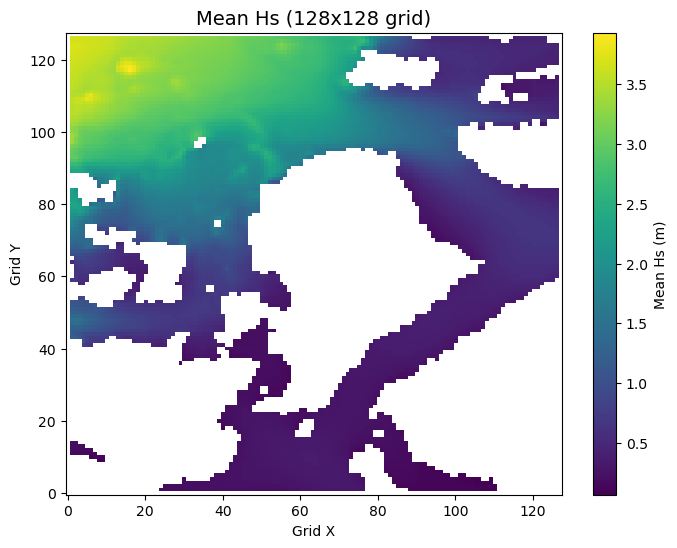

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
nc_file = "E:/Dataset/met_waves/Swan_cropped/swanSula201701_cropped.nc"  # 替换为你的文件路径
ds = xr.open_dataset(nc_file)

# 提取 hs 数据，假设 hs 是需要处理的变量
hs = ds['hs']  # 替换为实际的变量名

# 按时间维度求平均
hs_mean = hs.mean(dim='time', skipna=True)  # 确保忽略 NaN 值

# 绘制二维网格图
plt.figure(figsize=(8, 6))
plt.imshow(hs_mean, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label="Mean Hs (m)")
plt.title("Mean Hs (128x128 grid)", fontsize=14)
plt.xlabel("Grid X")
plt.ylabel("Grid Y")

# 保存或显示图片
plt.savefig("mean_hs_128x128_simple.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
import numpy as np
min_val = np.nanmin(Hs)
max_val = np.nanmax(Hs)
print(max_val,min_val)

9.96921e+36 0.0


In [26]:
import xarray as xr
file_path = "E:/Dataset/met_waves/test/swanSula202001_cropped.nc"
# 打开 .nc 文件
with xr.open_dataset(file_path) as ds:
    print(ds.variables)
    # 提取所需特征
    Hs = ds['hs'].values
    dirm = ds['theta0'].values
    print(Tm.shape)
    print(dirm[111:114,116:119,110:113])

Frozen({'hs': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      hs, 'tm02': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          s
    standard_name:  sea_surface_wave_mean_period_from_variance_spectral_densi...
    long_name:      tm02, 'theta0': <xarray.Variable (time: 744, latitude: 128, longitude: 128)>
[12189696 values with dtype=float64]
Attributes:
    units:          degrees
    standard_name:  sea_surface_wave_from_direction
    long_name:      theta0, 'time': <xarray.IndexVariable 'time' (time: 744)>
array(['2020-01-01T00:00:00.000000000', '2020-01-01T01:00:00.000000000',
       '2020-01-01T02:00:00.000000000', ..., '2020-01-31T21:00:00.000000000',
       '2020-01-31T22:00:00.000000000', '2020-01-31T23:00:00.000000000'],
      dtype='datetime64[

In [27]:
import numpy as np
min_val = np.nanmin(dirm)
max_val = np.nanmax(dirm)
print(max_val,min_val)

359.7005005450829 0.27035189862590453


In [22]:
def replace_invalid_values(data):
    """
    将数据中值为 -32768、9999.0 或 NaN 的位置替换为 0。

    参数：
    - data: torch.Tensor，输入数据张量。

    返回：
    - 处理后的 torch.Tensor。
    """
    if isinstance(data, np.ndarray):
        data = torch.tensor(data)
    # 替换 NaN 值为 0
    data = torch.nan_to_num(data, nan=0.0)
    # 替换 -32768 和 9999.0 为 0
    data = torch.where((data == -32768) | (data == 9999.0), 0.0, data)
    print("done")
    return data


In [23]:
import xarray as xr
file_path = "/home/hy4080/met_waves/Swan_cropped/swanSula202001_cropped.nc"
# 打开 .nc 文件
with xr.open_dataset(file_path) as ds:
    # print(ds.variables)
    
    # 提取所需特征
    Hs = ds['hs'].values
    Hs=replace_invalid_values(Hs)
    dirm = ds['theta0'].values
    print(dirm[111:114,116:119,110:113],Hs[111:114,116:119,110:113])

done
[[[258.4556898  261.97369949 262.85146513]
  [253.01691877 255.28471976 256.68139963]
  [250.03885168 251.62759476 252.87517401]]

 [[260.34522633 264.0291623  264.9675309 ]
  [254.51098426 256.80971925 258.29090049]
  [251.50167766 253.0113717  254.25442824]]

 [[265.0044275  268.96238818 269.71191906]
  [258.72134462 261.07698796 262.47801281]
  [255.59943488 257.00002922 258.15043331]]] tensor([[[0.8931, 0.8460, 0.8123],
         [0.9473, 0.9167, 0.8894],
         [0.9632, 0.9461, 0.9280]],

        [[0.8148, 0.7682, 0.7335],
         [0.8693, 0.8374, 0.8084],
         [0.8907, 0.8721, 0.8519]],

        [[0.6700, 0.6294, 0.5981],
         [0.7163, 0.6880, 0.6623],
         [0.7422, 0.7247, 0.7061]]], dtype=torch.float64)


In [24]:
import torch
import numpy as np

def normalize(data):
    # 归一化到[-1,1]
    x_min = torch.min(data)
    x_max = torch.max(data)
    data = 2 * (data - x_min) / (x_max - x_min) - 1
    return data
hs=normalize(Hs)
# dirm=normalize(dirm).numpy
min_val = torch.min(hs)
max_val = torch.max(hs)
print(max_val,min_val)

tensor(1., dtype=torch.float64) tensor(-1., dtype=torch.float64)


In [25]:
data=np.load("data/generated_wave_fields.npy")
hs=data[:,0,:,:]
min_val = np.nanmin(hs)
max_val = np.nanmax(hs)
print(max_val,min_val)

-0.52512723 -0.9766478


In [14]:
data=np.load("data/buoy_data_train.npy")
hs=data[:,:,0]
min_val = np.nanmin(hs)
max_val = np.nanmax(hs)
print(max_val,min_val)

1.0 -1.0


In [6]:
def normalize_zero_to_neg1_1(max_val, min_val):
    # 计算归一化到 -1, 1 区间时 0 对应的值
    normalized_value = -2 * (min_val) / (max_val - min_val) - 1
    return normalized_value

# 示例：假设某特征的最大值和最小值
max_val = 16.112773895263672
min_val = 0
zero_norm = normalize_zero_to_neg1_1(max_val, min_val)
print("归一化到[-1, 1]后，0对应的值为：", zero_norm)


归一化到[-1, 1]后，0对应的值为： -1.0
